In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Create a model to predict the delays

#### Through this workbook,I am goin to answer below questions:
* Create a model to predict flight delays?
* How well does weather predict plane delays?

In [2]:
df_2008=pd.read_csv('2008.csv')
df_2007=pd.read_csv('2007.csv')
airport_df=pd.read_csv('airports.csv')
carrier_df=pd.read_csv('carriers.csv')
planes_df=pd.read_csv('plane-data.csv')
main_df=pd.concat([df_2008],ignore_index=True)

In [3]:
main_df['Date']=pd.to_datetime(pd.DataFrame({'year':main_df['Year'],'month':main_df['Month'],'day':main_df['DayofMonth']}))

#### Problem statement - Is there any delay in the flight or not? If there is a delay do that is Dep Delay or Arr Delay or both or None. IF so how much of departure delay and how much of arrival delay
There are two regression problems in this questions.
#### Problem Statement1 - How much is Departure Delay for this particural plane
#### Problem Statement2 - How much is Arrival Delay for this particural plane
Key parameters can be considered are:
Target parameter: DepDelay or Arr Delay (Prepare a column Total Delay)
#### Problem1 model below

In [4]:
main_df.columns
key_columns=['CRSDepTime','CRSArrTime','UniqueCarrier','AirTime','Diverted','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay',
            'LateAircraftDelay','Month','DayOfWeek','DepDelay']
key2_columns=['UniqueCarrier','Diverted','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay',
            'LateAircraftDelay','Month','DayOfWeek','DepDelay']

In [5]:
main_df_req=main_df[key2_columns].copy()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


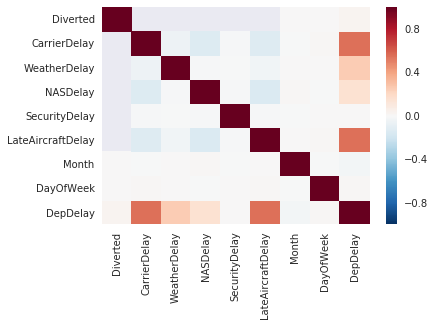

In [6]:
sns.heatmap(main_df_req.corr())

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


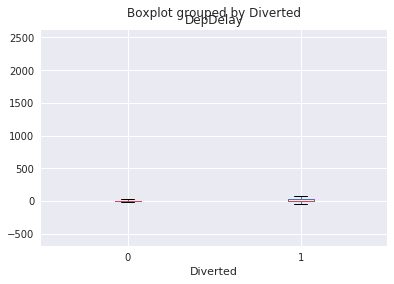

In [7]:
main_df_req.boxplot(column='DepDelay',by='Diverted')

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


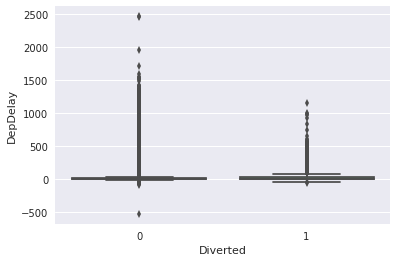

In [8]:
sns.boxplot(x='Diverted',y='DepDelay',data=main_df_req)

In [9]:
main_df_req['DepDelay'].describe(percentiles=[0.01,0.05,0.95,0.99])

count    6.873482e+06
mean     9.972570e+00
std      3.531127e+01
min     -5.340000e+02
1%      -1.200000e+01
5%      -9.000000e+00
50%     -1.000000e+00
95%      7.000000e+01
99%      1.640000e+02
max      2.467000e+03
Name: DepDelay, dtype: float64

In [10]:
print(main_df_req.columns)
lst=list(main_df_req['UniqueCarrier'].unique())
print(lst)
main_df_req1=main_df_req[main_df_req['DepDelay'].isnull()==False].fillna(0)

Index(['UniqueCarrier', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'Month', 'DayOfWeek', 'DepDelay'],
      dtype='object')
['WN', 'XE', 'YV', 'OH', 'OO', 'UA', 'US', 'DL', 'EV', 'F9', 'FL', 'HA', 'MQ', 'NW', '9E', 'AA', 'AQ', 'AS', 'B6', 'CO']


In [11]:
main_df['DayOfWeek'].unique()

array([4, 5, 6, 7, 1, 2, 3])

In [12]:
Unq_carr=tf.feature_column.categorical_column_with_hash_bucket('UniqueCarrier',hash_bucket_size=20)
diver=tf.feature_column.categorical_column_with_vocabulary_list('Diverted',[1,0])
Car_del=tf.feature_column.numeric_column('CarrierDelay')
wt_del=tf.feature_column.numeric_column('WeatherDelay')
Nas_del=tf.feature_column.numeric_column('NASDelay')
Sec_del=tf.feature_column.numeric_column('SecurityDelay')
Late_del=tf.feature_column.numeric_column('LateAircraftDelay')
Month=tf.feature_column.categorical_column_with_vocabulary_list('Month',[1,2,3,4,5,6,7,8,9,10,11,12])
DayOfWeek=tf.feature_column.categorical_column_with_vocabulary_list('DayOfWeek',[1,2,3,4,5,6,7])
DepDelay=tf.feature_column.numeric_column('DepDelay')
Unq_car=tf.feature_column.indicator_column(Unq_carr)
diverted=tf.feature_column.indicator_column(diver)
day_week=tf.feature_column.indicator_column(DayOfWeek)
day_mnth=tf.feature_column.indicator_column(Month)

In [13]:
feat_cols=[Unq_car,diverted,Car_del,wt_del,Nas_del,Sec_del,Late_del,day_mnth,day_week]
x_train,x_test,y_train,y_test=train_test_split(main_df_req1.iloc[:,:-1],main_df_req1.iloc[:,-1],random_state=100,train_size=0.8)

Create an input function

In [14]:
input_func=tf.estimator.inputs.pandas_input_fn(x=x_train,y=y_train,batch_size=100,num_epochs=11,shuffle=False)
test_func=tf.estimator.inputs.pandas_input_fn(x=x_test,y=y_test,batch_size=100,num_epochs=11,shuffle=False)

Create DNNRegressor model

In [15]:
model=tf.estimator.DNNRegressor(feature_columns=feat_cols,hidden_units=[10,30,30,30,10],activation_fn=tf.nn.relu,
                                optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.05,l1_regularization_strength=0.001),
                               model_dir=os.getcwd()+'/model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8991086198>, '_num_ps_replicas': 0, '_service': None, '_model_dir': '/content/datalab/notebooks/model', '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_task_type': 'worker', '_task_id': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_log_step_count_steps': 100, '_is_chief': True, '_master': '', '_num_worker_replicas': 1}


In [16]:
print(os.getcwd())

/content/datalab/notebooks


In [17]:
model.train(input_fn=input_func,steps=2500)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /content/datalab/notebooks/model/model.ckpt-2500
INFO:tensorflow:Saving checkpoints for 2501 into /content/datalab/notebooks/model/model.ckpt.
INFO:tensorflow:loss = 7025.4, step = 2501
INFO:tensorflow:global_step/sec: 256.25
INFO:tensorflow:loss = 6939.789, step = 2601 (0.396 sec)
INFO:tensorflow:global_step/sec: 268.443
INFO:tensorflow:loss = 8099.621, step = 2701 (0.372 sec)
INFO:tensorflow:global_step/sec: 278.93
INFO:tensorflow:loss = 10227.656, step = 2801 (0.357 sec)
INFO:tensorflow:global_step/sec: 285.048
INFO:tensorflow:loss = 4889.798, step = 2901 (0.351 sec)
INFO:tensorflow:global_step/sec: 282.107
INFO:tensorflow:loss = 4174.12, step = 3001 (0.357 sec)
INFO:tensorflow:global_step/sec: 281.713
INFO:tensorflow:loss = 4351.1445, step = 3101 (0.355 sec)
INFO:tensorflow:global_step/sec: 278.806
INFO:tensorflow:loss = 5853.966, step = 3201 (0.360 sec)
INFO:tensorflow:global_step/sec: 269.284
IN

In [241]:
ev=model.evaluate(input_fn=input_func,steps=100)
print(ev)
# towfurther tweak the model if we add rmse is part of evaluation metrics https://www.tensorflow.org/versions/r1.3/extend/estimators#constructing-modelfn

INFO:tensorflow:Starting evaluation at 2018-05-04-16:20:15
INFO:tensorflow:Restoring parameters from /content/datalab/notebooks/model/model.ckpt-2500
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2018-05-04-16:20:15
INFO:tensorflow:Saving dict for global step 2500: average_loss = 82.01227, global_step = 2500, loss = 8201.227
{'global_step': 2500, 'average_loss': 82.01227, 'loss': 8201.227}


In [242]:
y_pred=model.predict(input_fn=test_func)
y_pred_test=model.predict(input_fn=input_func)
y_pred1=[]
for i in range(500000):
  y_pred1.append(next(y_pred))
exact_pred=[i['predictions'][0] for i in y_pred1]
y_train_pred=[]
for i in range(500000):
  y_train_pred.append(next(y_pred_test))
exact_train=[i['predictions'][0] for i in y_train_pred]

Exception ignored in: <generator object Estimator.predict at 0x7fb574e360f8>
Traceback (most recent call last):
  File "/usr/local/envs/py3env/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 440, in predict
    for key, value in six.iteritems(preds_evaluated)
  File "/usr/local/envs/py3env/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/envs/py3env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4647, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow.python.framework.ops.Graph'> objects


INFO:tensorflow:Restoring parameters from /content/datalab/notebooks/model/model.ckpt-2500
INFO:tensorflow:Restoring parameters from /content/datalab/notebooks/model/model.ckpt-2500


In [243]:
from sklearn.metrics import mean_squared_error,r2_score
#print(mean_squared_error(y_test[0:len(exact_pred)],exact_pred))
print("Model Accuracy on test data is {} ".format(r2_score(y_test[0:len(exact_pred)],exact_pred)))
#print(mean_squared_error(y_train[0:len(exact_train)],exact_train))
print("Model Accuracy on train data is {} ".format(r2_score(y_train[0:len(exact_pred)],exact_train)))

Model Accuracy on test data is 0.9299606595940411 
Model Accuracy on train data is 0.9270839339833001 


In [247]:
model.get_variable_value(model.get_variable_names()[0])

array([-0.34271473,  0.00671753,  0.11543884,  0.23377183,  0.09515811,
        0.34150186,  0.39087343,  0.04226578,  0.2889858 , -0.8780768 ],
      dtype=float32)

In [251]:
model.get_variable_value(model.get_variable_names()[5])

array([2.2519038e+06, 2.9160580e+07, 3.0388722e+07, 1.0951514e+07,
       3.5894281e+04, 1.0420382e+08, 5.1590788e+07, 8.7311859e+00,
       6.6957844e+07, 1.0641035e+08, 1.3827319e+07, 1.8864728e+06,
       1.2861621e+08, 9.7954576e+07, 3.7187860e+07, 1.3821417e+07,
       4.6945420e+07, 2.2584021e+02, 1.5907749e+08, 1.1645870e+08,
       8.5369024e+07, 2.4518869e+08, 1.4049160e+04, 1.8592948e+07,
       6.9605648e+07, 8.9832632e+07, 1.1188794e+07, 4.6288348e+07,
       1.5849202e+06, 1.3823688e+07], dtype=float32)

#### Prepare dummy dataset with various Weather delays to check the model delay
Q6. How well does weather predict plane delays?
Ans: As per below results Weatherdelay is linearly correlated with flight departure delays and resultant model correlation is 0.96
Methodology: 
            * Checked correlation coefficient in 2008 data set it is 0.267
            * Generated random dataset where all the other features are constant and only Wealther delay is varying as per normal distribution.
            * Predicted Departure delays for all these instances. To check modeled relation between weather delay and DepDelay.
        Result is Weather delays positively correlated, i.e, bad weather will make flight departure delayed, in a very positive sense.

In [50]:
main_df_req1.corr()

,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Month,DayOfWeek,DepDelay
Diverted,1.000000,-0.008783,-0.003649,-0.011490,-0.000963,-0.011331,0.001648,0.001474,0.023817
CarrierDelay,-0.008783,1.000000,-0.006361,0.021384,-0.002353,0.031086,-0.016642,0.008812,0.598834
WeatherDelay,-0.003649,-0.006361,1.000000,0.046730,-0.001231,0.025791,-0.004172,0.004388,0.276385
NASDelay,-0.011490,0.021384,0.046730,1.000000,0.002643,0.061160,-0.015686,0.001284,0.355861
SecurityDelay,-0.000963,-0.002353,-0.001231,0.002643,1.000000,0.002283,-0.003353,0.002486,0.024840
LateAircraftDelay,-0.011331,0.031086,0.025791,0.061160,0.002283,1.000000,-0.020374,0.009433,0.641781
Month,0.001648,-0.016642,-0.004172,-0.015686,-0.003353,-0.020374,1.000000,-0.005344,-0.030037
DayOfWeek,0.001474,0.008812,0.004388,0.001284,0.002486,0.009433,-0.005344,1.000000,0.015295
DepDelay,0.023817,0.598834,0.276385,0.355861,0.024840,0.641781,-0.030037,0.015295,1.000000


In [54]:
temp_df= pd.DataFrame({'WeatherDelay':np.random.randn(20000)*100})
temp_df['UniqueCarrier']='WN'
temp_df['Diverted']=0
temp_df['CarrierDelay']=0
temp_df['NASDelay']=0
temp_df['SecurityDelay']=0
temp_df['LateAircraftDelay']=0
temp_df['Month']=1
temp_df['DayOfWeek']=1
temp_df.describe()

,WeatherDelay,Diverted,CarrierDelay,NASDelay,SecurityDelay,LateAircraftDelay,Month,DayOfWeek
count,20000.000000,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0
mean,0.226873,0.0,0.0,0.0,0.0,0.0,1.0,1.0
std,99.468537,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-374.044919,0.0,0.0,0.0,0.0,0.0,1.0,1.0
25%,-66.592321,0.0,0.0,0.0,0.0,0.0,1.0,1.0
50%,0.482783,0.0,0.0,0.0,0.0,0.0,1.0,1.0
75%,67.727170,0.0,0.0,0.0,0.0,0.0,1.0,1.0
max,361.884709,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [55]:
pred_func=tf.estimator.inputs.pandas_input_fn(x=temp_df,batch_size=100,num_epochs=1,shuffle=False)

In [56]:
pred_temp_df=model.predict(pred_func)
temp_df_pred=[]
for i in pred_temp_df:
  temp_df_pred.append(i['predictions'][0])

INFO:tensorflow:Restoring parameters from /content/datalab/notebooks/model/model.ckpt-5000


In [57]:
temp_df['DepDelay']=temp_df_pred
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
WeatherDelay         20000 non-null float64
UniqueCarrier        20000 non-null object
Diverted             20000 non-null int64
CarrierDelay         20000 non-null int64
NASDelay             20000 non-null int64
SecurityDelay        20000 non-null int64
LateAircraftDelay    20000 non-null int64
Month                20000 non-null int64
DayOfWeek            20000 non-null int64
DepDelay             20000 non-null float64
dtypes: float64(2), int64(7), object(1)
memory usage: 1.5+ MB


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


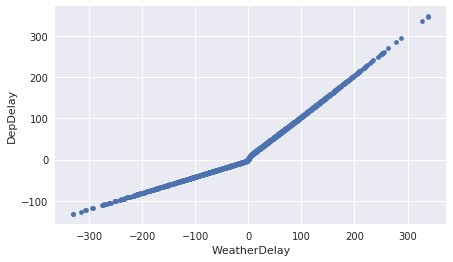

In [58]:
temp_df.iloc[0:2000,:].plot(kind='scatter',x='WeatherDelay',y='DepDelay',figsize=(7,4))